In [1]:
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import re
from scipy import signal
from matplotlib.dates import date2num
from matplotlib.collections import LineCollection
from scipy import optimize, interpolate
from scipy import stats
plt.rcParams['pdf.fonttype'] = 42

In [2]:
# データを読みこむ
data_tot = pd.read_csv("./dir_HS360\_results_individual.csv")
data_length = pd.read_csv("./_lengths_SL.csv")

ls = ["-", ":"]
lc = ["blue", "orange"]
sl = ["short", "long"]

cells = sorted(data_tot["CellID"].unique().tolist())  # originの細胞を重複なく抜き出す

data_plot = pd.DataFrame({})
for cell in cells:
    length_at_birth = data_length.loc[(data_length["Cell"] == cell) & (data_length["BD"] == "birth")]["Length"].values.tolist()[0]
    length_at_div = data_length.loc[(data_length["Cell"] == cell) & (data_length["BD"] == "division")]["Length"].values.tolist()[0]
    length_grow = length_at_div - length_at_birth

    df_RFP = data_tot.loc[data_tot["CellID"] == cell, " AverageBrightness(Seg)_C0"]
    df_FRET = data_tot.loc[data_tot["CellID"] == cell, " AverageBrightness(Seg)_C1"]
    df_CFP = data_tot.loc[data_tot["CellID"] == cell, " AverageBrightness(Seg)_C2"]
    df_ratio = df_FRET / df_CFP
    # 奇数の細胞番号はshort, 偶数の細胞番号はlong
    SL = int((cell + 1) % 2)
    sl_class = [sl[SL] for k in range(len(df_CFP))]
    el_t = [k*5 for k in range(len(df_CFP))]
    temp = pd.DataFrame([el_t, df_ratio, df_RFP, sl_class, [cell for i in range(len(df_ratio))]],
                        index=["time", "ratio", "RFP", "SL", "cell"])
    data_plot = pd.concat([data_plot, temp.T], ignore_index=True)
data_plot.to_csv("./_data_to_plot_asym_timecourse.csv")
print(data_plot)

     time     ratio         RFP     SL cell
0       0   1.62084   63.573427  short    1
1       5  1.612804   58.804348  short    1
2      10  1.643318   65.190955  short    1
3      15  1.669723   57.586207  short    1
4      20   1.61864   52.468085  short    1
...   ...       ...         ...    ...  ...
2206  130  1.906859  195.712389   long   50
2207  135  1.836621   208.12987   long   50
2208  140  1.539781   69.865672   long   50
2209  145  1.581632   45.231884   long   50
2210  150  1.629084   42.037736   long   50

[2211 rows x 5 columns]


In [3]:
def Mphase_detection(ys):
    n_time = len(ys)
    ys = [cmp for cmp in ys]
    diffs = np.zeros((n_time,))
    for i in range(n_time - 1):
        diffs[i] = ys[i+1] - ys[i]
    min_dif = min(diffs)
    frame_min = np.argmin(diffs)
    if diffs[frame_min - 1] < 0:
        frame_min = frame_min-1

    return frame_min, diffs

df = pd.read_csv('_data_to_plot_asym_timecourse.csv', index_col=0)
print(df)

cells = sorted(df["cell"].unique().tolist())  # stress sourceを重複なく抜き出す

df_tot2 = pd.DataFrame({})
df_tot3 = pd.DataFrame({})
SLs = ["long", "short"]
for cell in cells:
    df_temp = df.loc[df["cell"] == cell]
    
    df_RFP = df_temp["RFP"].to_list()
    df_ratio = df_temp["ratio"].to_list()
    frame_min, diff = Mphase_detection(df_RFP)
    times = [5*(i-frame_min) for i in range(len(df_RFP))]
    SL = [SLs[cell%2] for i in range(len(df_RFP))]
    cells = [cell for i in range(len(df_RFP))]
    temp = pd.DataFrame([times, df_ratio, df_RFP, SL, cells], index=["time", "ratio", "cyclin", "SL", "cell"])
    df_tot2 = pd.concat([df_tot2, temp.T], ignore_index=True)
    temp = pd.DataFrame([[df_ratio[frame_min]], [df_RFP[frame_min]], [df_ratio[np.argmax(df_RFP)]], [max(df_RFP)], [SLs[cell%2]], [cell]], 
                         index=["ratio-div", "RFP-div", "ratio-max", "RFP-max", "SL", "cell"])
    df_tot3 = pd.concat([df_tot3, temp.T], ignore_index=True)
n_cell = df['cell'].to_numpy()[-1]
print('number of cells = ', n_cell)
print(df_tot2)
print(df_tot3)

      time     ratio         RFP     SL  cell
0        0  1.620840   63.573427  short     1
1        5  1.612804   58.804348  short     1
2       10  1.643318   65.190955  short     1
3       15  1.669723   57.586207  short     1
4       20  1.618640   52.468085  short     1
...    ...       ...         ...    ...   ...
2206   130  1.906859  195.712389   long    50
2207   135  1.836621  208.129870   long    50
2208   140  1.539781   69.865672   long    50
2209   145  1.581632   45.231884   long    50
2210   150  1.629084   42.037736   long    50

[2211 rows x 5 columns]
number of cells =  50
      time     ratio      cyclin     SL cell
0     -195   1.62084   63.573427  short    1
1     -190  1.612804   58.804348  short    1
2     -185  1.643318   65.190955  short    1
3     -180  1.669723   57.586207  short    1
4     -175   1.61864   52.468085  short    1
...    ...       ...         ...    ...  ...
2206    -5  1.906859  195.712389   long   50
2207     0  1.836621   208.12987   long  

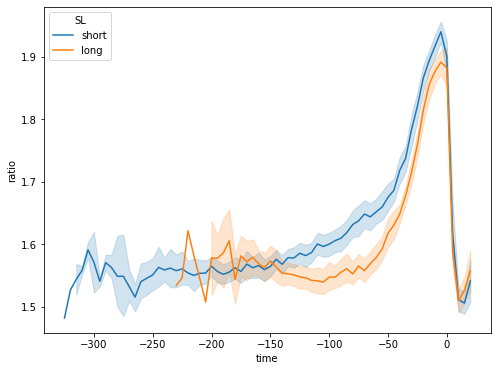

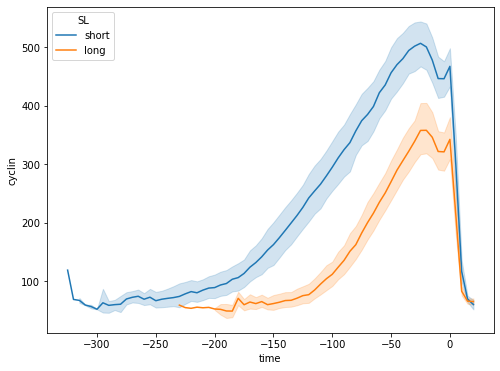

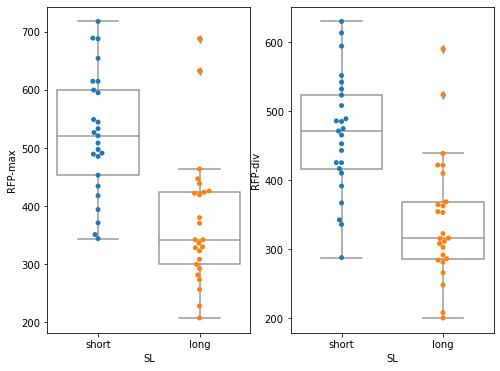

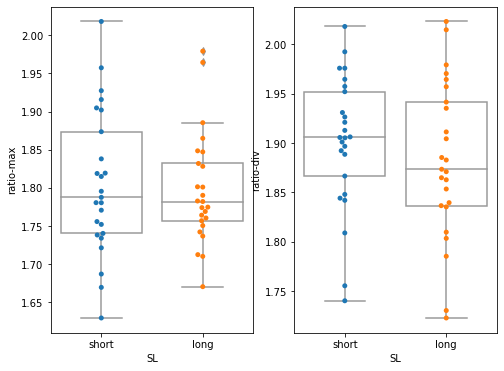

In [6]:
fig = plt.figure(figsize=(8,6))
sns.lineplot(x="time", y="ratio", data=df_tot2, hue="SL", ci=95)
plt.show()

fig = plt.figure(figsize=(8,6))
sns.lineplot(x="time", y="cyclin", data=df_tot2, hue="SL", ci=95)
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(8,6))
sns.swarmplot(x="SL", y="RFP-max", data=df_tot3, ax=ax[0])
sns.boxplot(x="SL", y="RFP-max", data=df_tot3, ax=ax[0], color="white")
sns.swarmplot(x="SL", y="RFP-div", data=df_tot3, ax=ax[1])
sns.boxplot(x="SL", y="RFP-div", data=df_tot3, ax=ax[1], color="white")
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(8,6))
sns.swarmplot(x="SL", y="ratio-max", data=df_tot3, ax=ax[0])
sns.boxplot(x="SL", y="ratio-max", data=df_tot3, ax=ax[0], color="white")
sns.swarmplot(x="SL", y="ratio-div", data=df_tot3, ax=ax[1])
sns.boxplot(x="SL", y="ratio-div", data=df_tot3, ax=ax[1], color="white")
plt.show()
